# Second demo 


# Level: Advance


# Classification of fashion article images using a custom model with custom layers (Residual Network)


Following end-to-end workflow disceminates images of Fashion-MNIST dataset. 


#### The goals to write the following programs are as follow:

1. Implementing model subclassing API with custom layers to create a residual network architecture

2. Implementing custom training loop

3. Implementing the automatic differentiation tool in Tensorflow to calculate the gradients for backpropagation.


##### Database: Fashion-MNIST dataset

 * train-labels = "https://storage.googleapis.com/tensorflow/tf-keras-datasets/train-labels-idx1-ubyte.gz"

 * train-images = "https://storage.googleapis.com/tensorflow/tf-keras-datasets/train-images-idx3-ubyte.gz"

 * test_labels = "https://storage.googleapis.com/tensorflow/tf-keras-datasets/t10k-labels-idx1-ubyte.gz"

 * test_images = "https://storage.googleapis.com/tensorflow/tf-keras-datasets/t10k-images-idx3-ubyte.gz"



In [1]:

import tensorflow as tf
import numpy as np
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
import time
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, BatchNormalization, Conv2D, Dense, Flatten, Add , Softmax, concatenate


In [ ]:
# Loading the Fashion-MNIST dataset

(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

train_images = train_images.astype(np.float32)
test_images = test_images.astype(np.float32)

train_images = train_images[:5000] / 255.
train_labels = train_labels[:5000]

test_images = test_images / 255.

train_images = train_images[..., np.newaxis]
test_images = test_images[..., np.newaxis]

4423680/4422102 [==============================] - 0s 0us/step


In [ ]:
# Creating Dataset objects for the training and test sets

train_dataset = tf.data.Dataset.from_tensor_slices((train_images, train_labels))
train_dataset = train_dataset.batch(32)

test_dataset = tf.data.Dataset.from_tensor_slices((test_images, test_labels))
test_dataset = test_dataset.batch(32)

In [ ]:
# Getting dataset labels

image_labels = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

In [2]:

"""

Creating a first custom layer: Block_A

"""

class Block_A(Layer):
    
    def __init__(self, **kwargs):
        super(Block_A, self).__init__(**kwargs)
        
        
    def build(self, input_shape):

        self.blkA_BN_1 = BatchNormalization (input_shape= input_shape )
        
        self.blkA_Conv2d_1 = Conv2D(input_shape[-1], (3,3) ,padding= 'SAME',name='blkA_Conv2d_1')
        
        self.blkA_BN_2 = BatchNormalization()
        
        self.blkA_Conv2d_2 = Conv2D(input_shape[-1], (3,3) ,padding= 'SAME',name='blkA_Conv2d_2')
        
        
        
    def call(self, inputs, training=False):

        x= self.blkA_BN_1(inputs,training=training)
        x=tf.nn.relu(x)
        x=self.blkA_Conv2d_1(x)
        x=self.blkA_BN_2(x,training=training)
        x=tf.nn.relu(x)
        x=self.blkA_Conv2d_2(x)
        x= inputs + x
        return x
    
    """
    input_shape[-1] indicats number of filter in conv2d()
    
    """


In [3]:
test_model = tf.keras.Sequential([Block_A(input_shape=(28, 28, 1), name="block_A")])
test_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block_A (Block_A)            (None, 28, 28, 1)         28        
Total params: 28
Trainable params: 24
Non-trainable params: 4
_________________________________________________________________


In [4]:
"""
Creating a second custom layer

"""

class Block_B(Layer):

    def __init__(self, out_filters, **kwargs):

        super(Block_B, self).__init__(**kwargs)
        self.out_filters=out_filters
        
        
        
    def build(self, input_shape):
        
        self.blkB_BN_1 = BatchNormalization(input_shape=input_shape) 
        self.blkB_conv2d_1 = Conv2D(input_shape[-1],(3,3),padding= 'SAME',name = 'blkB_conv2d_1')
        self.blkB_BN_2 = BatchNormalization() 
        self.blkB_conv2d_2 = Conv2D(self.out_filters,(3,3),padding= 'SAME', name = 'blkB_conv2d_2')
        self.blkB_conv2d_3 = Conv2D(self.out_filters,(1,1),padding= 'SAME', name = 'blkB_conv2d_3')
        
        
        
    def call(self, inputs, training=False):

        x = self.blkB_BN_1(inputs,training=training)
        x = tf.nn.relu(x)
        x = self.blkB_conv2d_1(x)
        x = self.blkB_BN_2(x)
        x = tf.nn.relu(x)
        x = self.blkB_conv2d_2(x)
        x = x + self.blkB_conv2d_3(inputs)
        return x
        
        

In [5]:
test_model = tf.keras.Sequential([Block_B(16, input_shape=(32, 32, 3), name="block_B")])
test_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block_B (Block_B)            (None, 32, 32, 16)        620       
Total params: 620
Trainable params: 608
Non-trainable params: 12
_________________________________________________________________


In [6]:
"""
Creating a custom model that integrate both created custom layers

"""

class ResidualCustomNetModel(Model):

    def __init__(self, **kwargs):
        
        super(ResidualCustomNetModel, self).__init__(**kwargs)

        self.mdl_conv2d_1 = Conv2D(32,(7,7),padding= 'SAME',strides = 2, name = 'mdl_conv2d_1')
        self.mdl_Block_A = Block_A()
        self.mdl_conv2d_2 = Conv2D(32,(3,3),padding= 'SAME',strides = 2, name = 'mdl_conv2d_2')
        self.mdl_Block_B = Block_B(64)
        self.mdl_flatten_layer = Flatten()
        self.mdl_dense = Dense(10,activation='softmax')
        
        
        
    def call(self, inputs, training=False):
       
        x= self.mdl_conv2d_1(inputs)
        x= self.mdl_Block_A(x,training=True)
        x= self.mdl_conv2d_2(x)
        x= self.mdl_Block_B(x, training=True)
        x= self.mdl_flatten_layer(x)
        x= self.mdl_dense(x)
        
        return x
        

In [8]:
"""Create the model"""

resnet_model = ResidualCustomNetModel()


In [ ]:
"""" Define the optimizer and loss function """"

optimizer_obj = tf.keras.optimizers.Adam(learning_rate=0.001)
loss_obj = tf.keras.losses.SparseCategoricalCrossentropy()

In [ ]:
""""Defining the grad function""""

@tf.function
def grad(model, inputs, targets, loss):

    with tf.GradientTape() as tape:
        
        prediction = model(inputs)
        
        current_loss =loss(targets,prediction)
        
        grads = tape.gradient( current_loss, model.trainable_variables )
        
        return current_loss, grads
    
    
    

In [ ]:
"""Defining the custom training loop"""

def train_resnet(model, num_epochs, dataset, optimizer, loss, grad_fn):

    start_time = time.time()
    
    # save records for plotting
    train_loss_results = []
    train_accuracy_results = []



    for epoch in range(num_epochs):
  
        epoch_loss_avg= tf.keras.metrics.Mean()
        epoch_accuracy= tf.keras.metrics.CategoricalAccuracy()

            # Training loop
        for inputs , targets in dataset:
        
            #Optimize the model
            loss_value , grads = grad_fn(model, inputs , targets, loss)
            optimizer.apply_gradients(zip(grads,model.trainable_variables))
            
            # Compute current loss
            epoch_loss_avg(loss_value)
            
            # Compute predicted label vs actual label
            epoch_accuracy(to_categorical(targets), model(inputs))

        #End of epoch
        train_loss_results.append(epoch_loss_avg.result())
        train_accuracy_results.append(epoch_accuracy.result())

        print("Epoch {:03d}: Loss: {:.3f} , Accuracy: {:.3%} ".format(epoch,
                                                                epoch_loss_avg.result(),
                                                                epoch_accuracy.result()))
    
    print("Duration :{:.3f}".format(time.time() - start_time)) 
    
    return train_loss_results, train_accuracy_results
       

In [ ]:
# Train the model
# epoch is 8

train_loss_results, train_accuracy_results = train_resnet(resnet_model, 8, train_dataset, optimizer_obj, loss_obj, grad)

Epoch 000: Loss: 0.680 , Accuracy: 81.320% 
Epoch 001: Loss: 0.406 , Accuracy: 88.080% 
Epoch 002: Loss: 0.310 , Accuracy: 92.280% 
Epoch 003: Loss: 0.244 , Accuracy: 94.980% 
Epoch 004: Loss: 0.227 , Accuracy: 95.640% 
Epoch 005: Loss: 0.221 , Accuracy: 96.120% 
Epoch 006: Loss: 0.190 , Accuracy: 96.740% 
Epoch 007: Loss: 0.161 , Accuracy: 97.760% 
Duration :473.056


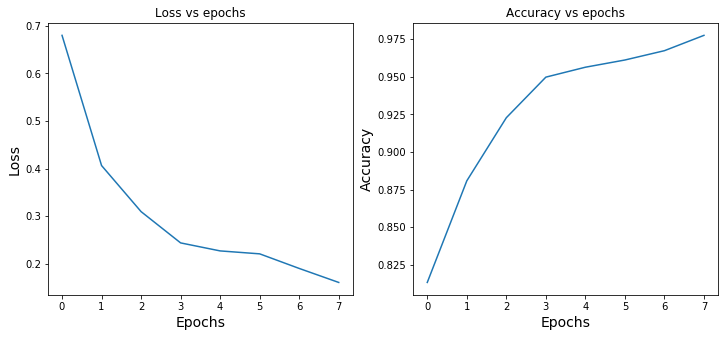

In [ ]:
# Computing the train loss and accuracy

fig, axes = plt.subplots(1, 2, sharex=True, figsize=(12, 5))

axes[0].set_xlabel("Epochs", fontsize=14)
axes[0].set_ylabel("Loss", fontsize=14)
axes[0].set_title('Loss vs epochs')
axes[0].plot(train_loss_results)

axes[1].set_title('Accuracy vs epochs')
axes[1].set_ylabel("Accuracy", fontsize=14)
axes[1].set_xlabel("Epochs", fontsize=14)
axes[1].plot(train_accuracy_results)
plt.show()

In [ ]:
# Computing the test loss and accuracy

epoch_loss_avg = tf.keras.metrics.Mean()
epoch_accuracy = tf.keras.metrics.CategoricalAccuracy()

for x, y in test_dataset:
    model_output = resnet_model(x)
    epoch_loss_avg(loss_obj(y, model_output))  
    epoch_accuracy(to_categorical(y), model_output)

print("Test loss: {:.3f}".format(epoch_loss_avg.result().numpy()))
print("Test accuracy: {:.3%}".format(epoch_accuracy.result().numpy()))

Test loss: 0.696
Test accuracy: 83.240%


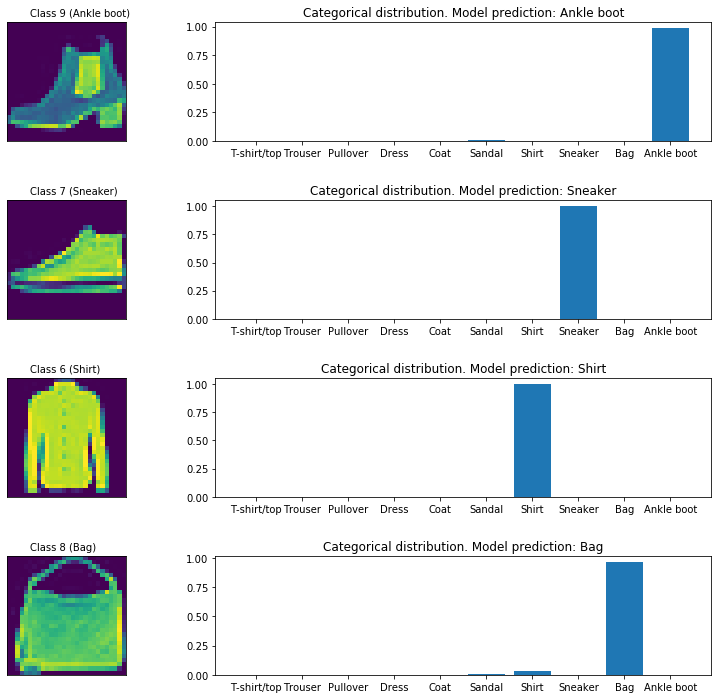

In [ ]:
"""Model predictions"""

num_test_images = test_images.shape[0]

random_inx = np.random.choice(test_images.shape[0], 4)
random_test_images = test_images[random_inx, ...]
random_test_labels = test_labels[random_inx, ...]

predictions = resnet_model(random_test_images)

fig, axes = plt.subplots(4, 2, figsize=(16, 12))
fig.subplots_adjust(hspace=0.5, wspace=-0.2)

for i, (prediction, image, label) in enumerate(zip(predictions, random_test_images, random_test_labels)):
    axes[i, 0].imshow(np.squeeze(image))
    axes[i, 0].get_xaxis().set_visible(False)
    axes[i, 0].get_yaxis().set_visible(False)
    axes[i, 0].text(5., -2., f'Class {label} ({image_labels[label]})')
    axes[i, 1].bar(np.arange(len(prediction)), prediction)
    axes[i, 1].set_xticks(np.arange(len(prediction)))
    axes[i, 1].set_xticklabels(image_labels, rotation=0)
    pred_inx = np.argmax(prediction)
    axes[i, 1].set_title(f"Categorical distribution. Model prediction: {image_labels[pred_inx]}")
    
plt.show()